# Imports

In [1]:
import pandas as pd
import time
import numpy as np
import string
import torch

import random
# For deterministic results. 
SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# For visualizations
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import string

from sklearn.model_selection import train_test_split

# Load/Data Exploration

In [2]:
#Read the data
start = time.time()
df = pd.read_csv("./dataset/lyrics.csv")
end = time.time()

#Print the time it took to load the data
print("Time to load the data: ", end - start)

Time to load the data:  1.9285495281219482


In [3]:
#Show the first 5 rows
df.head()

,Unnamed: 0,artist,seq,song,label
0,0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday,0.626
1,1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die,0.630
2,2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside,0.240
3,3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot,0.536
4,4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds,0.371


In [4]:
#Show the last 5 rows
df.tail()

,Unnamed: 0,artist,seq,song,label
158348,158348,Adam Green,"And we live on borrowed time,\r\nBut this head...",Friends of Mine,0.737
158349,158349,Adam Green,Frozin in time forever\r\nCarrying that torch ...,Frozen in Time,0.482
158350,158350,Adam Green,Hard to be a girl. \r\nSo nice to be a boy. \r...,Hard to Be a Girl,0.733
158351,158351,Adam Green,"I want to chose to die,\r\nAnd be buried with ...",I Wanna Die,0.361
158352,158352,Adam Green,Musical ladders\r\nLeaning on mountains\r\nBat...,Musical Ladders,0.263


In [5]:
#Summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158353 entries, 0 to 158352
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  158353 non-null  int64  
 1   artist      158353 non-null  object 
 2   seq         158353 non-null  object 
 3   song        158353 non-null  object 
 4   label       158353 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.0+ MB


In [6]:
#Describe statistics of the data
df.describe()

,Unnamed: 0,label
count,158353.000000,158353.000000
mean,79176.000000,0.491052
std,45712.717926,0.249619
min,0.000000,0.000000
25%,39588.000000,0.286000
50%,79176.000000,0.483000
75%,118764.000000,0.691000
max,158352.000000,0.998000


In [7]:
#Dimensions of the data as a tuple
df.shape

(158353, 5)

In [8]:
#Columns names of the data
df.columns

Index(['Unnamed: 0', 'artist', 'seq', 'song', 'label'], dtype='object')

In [9]:
#Data types of each column
df.dtypes

Unnamed: 0      int64
artist         object
seq            object
song           object
label         float64
dtype: object

In [10]:
#Missing or null values in the data
df.isnull()

,Unnamed: 0,artist,seq,song,label
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
158348,False,False,False,False,False
158349,False,False,False,False,False
158350,False,False,False,False,False
158351,False,False,False,False,False


# Data Preparation

In [11]:
#Creating a new column with the "sentiment" of the lyrics
def atribuir_sentimento(valor):
    if valor < 0.4:
        return 'negative'
    elif valor > 0.6:
        return 'positive'
    else:
        return 'neutral'

# Aplicar a função a cada valor da coluna 'label' e criar uma nova coluna 'sentiment'
df['sentiment'] = df['label'].apply(atribuir_sentimento)

In [12]:
df = df.rename(columns={'seq': 'lyrics'})
df = df[['lyrics', 'sentiment']]

In [13]:
#Removing unnecessary characters from lyrics
df['lyrics'] = df['lyrics'].str.replace("[\(\[].*?[\)\]]", '')
df['lyrics'] = df['lyrics'].str.replace("\n", ' ')
df['lyrics'] = df['lyrics'].str.replace("\r", ' ')
df['lyrics'] = df['lyrics'].str.lower()
df['lyrics'] = df['lyrics'].str.replace('[{}]'.format(string.punctuation), '')

<ipython-input-13-1849f94512e8>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lyrics'] = df['lyrics'].str.replace("[\(\[].*?[\)\]]", '')
<ipython-input-13-1849f94512e8>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lyrics'] = df['lyrics'].str.replace('[{}]'.format(string.punctuation), '')


In [14]:
def lyrics_to_words(document):
    """
    This function splits the text of lyrics to  single words, removing stopwords and doing the lemmatization to each word

    parameters:
    document: text to split to single words
    """
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

In [15]:
df

,lyrics,sentiment
0,no no i aint ever trapped out the bando but ...,positive
1,the drinks go down and smoke goes up i feel my...,positive
2,she dont live on planet earth no more she fou...,negative
3,trippin off that grigio mobbin lights low tri...,neutral
4,i see a midnight panther so gallant and so bra...,negative
...,...,...
158348,and we live on borrowed time but this headsho...,positive
158349,frozin in time forever carrying that torch fo...,neutral
158350,hard to be a girl so nice to be a boy in m...,positive
158351,i want to chose to die and be buried with a r...,negative


In [16]:
df['lyrics'] = df['lyrics'].apply(lyrics_to_words)

In [17]:
df

,lyrics,sentiment
0,aint ever trapped bando oh lord dont get wrong...,positive
1,drink go smoke go feel got let go care get los...,positive
2,dont live planet earth found love venus thats ...,negative
3,trippin grigio mobbin light low trippin grigio...,neutral
4,see midnight panther gallant brave found found...,negative
...,...,...
158348,live borrowed time headshot pretty good ive sc...,positive
158349,frozin time forever carrying torch long hear h...,neutral
158350,hard girl nice boy room night pretty site here...,positive
158351,want chose die buried rubix cube sleep inside ...,negative


# Data Visualization

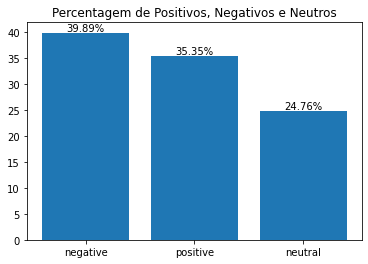

In [18]:
# Calcular a contagem de cada categoria
contagem = df['sentiment'].value_counts()

# Calcular as porcentagens
porcentagens = contagem / contagem.sum() * 100

# Criar o gráfico de colunas
plt.bar(porcentagens.index, porcentagens)

# Adicionar rótulos aos valores nas colunas
for i, valor in enumerate(porcentagens):
    plt.text(i, valor, f'{valor:.2f}%', ha='center', va='bottom')

# Adicionar título ao gráfico
plt.title('Percentagem de Positivos, Negativos e Neutros')

# Exibir o gráfico
plt.show()

# Split data to CSV

In [39]:
# Dividir os dados em treinamento e teste de forma balanceada
#train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

# Salvar o dataframe original em um arquivo CSV
#df.to_csv('original_data.csv', index=False)

# Selecionar apenas as colunas 'seq' e 'sentiment' para o conjunto de teste
#test_data = test_data[['lyrics', 'sentiment']]

# Remover linhas com valores ausentes do conjunto de treinamento
#train_data = train_data.dropna()

# Gravar o conjunto de treinamento em um arquivo CSV
#train_data.to_csv('train.csv', index=False)

# Remover linhas com valores ausentes do conjunto de teste
#test_data = test_data.dropna()

# Gravar o conjunto de teste em um arquivo CSV
#test_data.to_csv('test.csv', index=False)